<div class="alert alert-info">
<strong>Анализ аномалий в потреблении тепла<strong>

Виды аномалий по показаниям приборов учёта тепловой энергии, которые необходимо выявлять (кроме объектов с видом энергопотребления ГВС (централ):

1. нулевые значения показаний за тепловую энергию в отопительный период (октябрь-апрель);
2. равные значения показаний в течение нескольких расчетных периодов;
3. снижение/рост показаний в отдельные месяцы по сравнению с показаниями за предыдущие периоды по данному объекту (с учётом фактической температуры наружного воздуха и количества отопительных дней в месяце);
4. аномально низкое/высокое (отклонение более 25%) потребление объекта в конкретном месяце по сравнению с аналогичными объектами (только для типов объекта «Многоквартирный дом») по критериям:
- год постройки (по группам до 1958 г., 1959-1989 гг., 1990-2000 гг., 2001-2010 гг., 2011-2024 гг.),
- этажность (по группам 1-2 этажа, 3-4 этажа, 5-9 этажей,10-12 этажей, 13 и более этажей),
- площадь (±10%),
- наличие ГВС ИТП (горячей воды, учитываемой тем же прибором).

### <div style="border: 1px solid purple; padding: 10px; color: SteelBlue">Импорт</div>

In [ ]:
# для запуска в colab
!pip install -q tensorflow
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno


from sklearn.metrics import classification_report,accuracy_score,f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import load_model

pd.set_option("display.max_colwidth", None)
pd.set_option('future.no_silent_downcasting', True)

In [ ]:
# для запуска указать директорию с файлом zip
!unzip -q '/content/drive/MyDrive/аномалии.zip' -d data

# !unzip '/home/olgatorres/Загрузки/ТУРБО/аномалии/аномалии.zip' -d data

In [ ]:
data_dir = '/content/data'
# data_dir = '/home/olgatorres/Загрузки/ТУРБО/data'

В данных есть файл с температурами и файл с информацией об объектах. Они отличаются по кол-ву столбцов от общих данных.

In [ ]:
buff = []
for filename in os.listdir(data_dir):
    if filename.endswith(".xlsx") or filename.endswith(".xls"):
        file_path = os.path.join(data_dir, filename)
        df = pd.read_excel(file_path, skiprows=1)
        if len(df.columns) == 7:
            buff.append(df)
        elif len(df.columns) < 7:
            df_info = df.copy()
        else:
            temperature = df.copy()
df = pd.concat(buff, ignore_index=True)

### <div style="border: 1px solid purple; padding: 10px; color: SteelBlue">EDA</div>

#### <div style="border: 1px solid purple; padding: 10px; color: SteelBlue">Файл с показаниями</div>

In [ ]:
df.head()

,Подразделение,№ ОДПУ,Вид энерг-а ГВС,Адрес объекта,Тип объекта,Дата текущего показания,"Текущее потребление, Гкал"
0,Уфа,787,ГВС-ИТП,г Уфа,Другое строение,2023-05-01,65.000
1,Уфа,00119540,ГВС-ИТП,"г Уфа, б-р. Баландина, д.11",Многоквартирный дом,2023-05-01,128.706
2,Уфа,30822,ГВС-ИТП,"г Уфа, б-р. Баландина, д.2",Многоквартирный дом,2023-05-01,231.470
3,Уфа,237959,NaN,"г Уфа, б-р. Баландина, д.2а",Другое строение,2023-05-01,12.095
4,Уфа,145046,ГВС-ИТП,"г Уфа, б-р. Баландина, д.4",Многоквартирный дом,2023-05-01,73.436


In [ ]:
df.describe(include='object')

,Подразделение,№ ОДПУ,Вид энерг-а ГВС,Адрес объекта,Тип объекта
count,75646,75646,29176,75646,75646
unique,1,4637,2,4281,21
top,Уфа,1600449,ГВС-ИТП,"г Уфа, ул. Достоевского, д.132",Многоквартирный дом
freq,75646,48,28921,215,54295


Переименуем для удобства работы.

In [ ]:
cols_dict = {
    "Подразделение": "division",
    "№ ОДПУ": "num_odpu",
    "Вид энерг-а ГВС": "hot_water",
    "Адрес объекта": "address",
    "Тип объекта": "object_type",
    "Дата текущего показания": "date",
    "Текущее потребление, Гкал": "current_consumption",
}
df.rename(columns=cols_dict, inplace=True)

Нам не нужны данные по ГВС (централ), это указано в задаче. Удаляем их.

In [ ]:
df = df[df.hot_water!= 'ГВС (централ)']

Так как нас интресует только отопительный период удаляем данные с мая по сентябрь включительно.\
В файле с температурами этот момент проверен.

In [ ]:
months = [5, 6, 7, 8, 9]

In [ ]:
df = df[~df.date.dt.month.isin(months)]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58380 entries, 171 to 75642
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   division             58380 non-null  object        
 1   num_odpu             58380 non-null  object        
 2   hot_water            18126 non-null  object        
 3   address              58380 non-null  object        
 4   object_type          58380 non-null  object        
 5   date                 53398 non-null  datetime64[ns]
 6   current_consumption  53398 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 3.6+ MB


Посмотрим на дубликаты.

In [ ]:
print(f"Количество дубликатов: {df[df.duplicated()].shape[0]}")

Количество дубликатов: 2016


In [ ]:
df[df.duplicated()].isna().sum()

,0
division,0
num_odpu,0
hot_water,1364
address,0
object_type,0
date,2014
current_consumption,2014


Мы видим, что все дубликаты содержат пропуски по интересующему нас столбцу с показаниями. Дата также отсутствует.\
Можно удалить данные строки.

In [ ]:
df = df.drop_duplicates()

In [ ]:
df.isna().sum()

,0
division,0
num_odpu,0
hot_water,38890
address,0
object_type,0
date,2968
current_consumption,2968


И удалим строки с пропусками по показаниям и дате, предварительно проверив, что их одинаковое кол-во.\
Эти данные нам ничего не дают.

In [ ]:
df[(df.date.isna()) & (df.current_consumption.isna())].shape[0]

2968

In [ ]:
df = df.dropna(subset=['date', 'current_consumption'])

#### <div style="border: 1px solid purple; padding: 10px; color: SteelBlue">Файл с информацией об объектах</div>

In [ ]:
df_info.head()

,Адрес объекта,Тип Объекта,Этажность объекта,Дата постройки,Общая площадь объекта
0,"г Уфа, б-р. Баландина, д.11",Многоквартирный дом,18,2011-01-01 00:00:00,5394.5
1,"г Уфа, б-р. Баландина, д.2",Многоквартирный дом,16,2012-01-01 00:00:00,12731.5
2,"г Уфа, б-р. Баландина, д.2а",Другое строение,3,NaN,0.0
3,"г Уфа, б-р. Баландина, д.4",Многоквартирный дом,16,2012-01-01 00:00:00,4234.9
4,"г Уфа, б-р. Баландина, д.4 корп.1",Многоквартирный дом,16,2012-01-01 00:00:00,4250.1


In [ ]:
df_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5873 entries, 0 to 5872
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Адрес объекта          5873 non-null   object 
 1   Тип Объекта            5873 non-null   object 
 2   Этажность объекта      5873 non-null   object 
 3   Дата постройки         4403 non-null   object 
 4   Общая площадь объекта  5749 non-null   float64
dtypes: float64(1), object(4)
memory usage: 229.5+ KB


In [ ]:
df_info.describe(include='object')

,Адрес объекта,Тип Объекта,Этажность объекта,Дата постройки
count,5873,5873,5873,4403
unique,5695,29,37,153
top,"г Уфа, ул. Ульяновых, д.65",Многоквартирный дом,5,1960-01-01 00:00:00
freq,8,3828,1354,151


Переименуем для удобства работы.

In [ ]:
cols_dict = {
    "Адрес объекта": "address",
    "Тип Объекта": "object_type",
    "Этажность объекта": "floors",
    "Дата постройки": "contruction_date",
    "Общая площадь объекта": "square",
}
df_info.rename(columns=cols_dict, inplace=True)

In [ ]:
df_info.floors.unique()

array([18, 16, 3, 24, 0, 30, 26, 25, 9, 12, 2, 11, 1, 10, 6, 14, 5, 7, 4,
       20, 15, 13, 19, 22, '1 всего', 17, 8, 27, '9 всего', '12 всего',
       21, '0 всего', 23, 28, '5 всего', 29, 32], dtype=object)

В столбце floors у нас есть значения: 0 всего, 9 всего, 5 всего, 12 всего. Приведем их к норм виду.\
С этажом 0 разберемся после объединения датафреймов.


In [ ]:
df_info.floors = df_info.floors.replace(
    {"0 всего": 0, "9 всего": 9, "5 всего": 5, "12 всего": 12}
)

Посмотрим на дубли, так как из describe видно, что адреса повторяются.

In [ ]:
print(f"Количество дубликатов: {df_info[df_info.duplicated()].shape[0]}")

Количество дубликатов: 1


In [ ]:
df_info = df_info.drop_duplicates()

In [ ]:
duplies = df_info[
    df_info.duplicated(subset=["address", "object_type"], keep=False)
].sort_values("address")
duplies

,address,object_type,floors,contruction_date,square
122,"г Уфа, б-р. Тухвата Янаби, д.34",Другое строение,1,NaN,0.01
123,"г Уфа, б-р. Тухвата Янаби, д.34",Другое строение,2,NaN,0.01
412,"г Уфа, пр-кт Октября, д.153",Другое строение,0,NaN,0.01
413,"г Уфа, пр-кт Октября, д.153",Другое строение,3,NaN,0.01
487,"г Уфа, пр-кт Октября, д.31",Другое строение,0,NaN,0.01
...,...,...,...,...,...
5728,"г Уфа, ул. Энтузиастов, д.6",Многоквартирный дом,9,1986-01-01 00:00:00,12006.70
5729,"г Уфа, ул. Энтузиастов, д.6",Многоквартирный дом,9,NaN,NaN
2032,"г Уфа, ул. им Фронтовых бригад, д.10",Другое строение,0,NaN,0.01
2033,"г Уфа, ул. им Фронтовых бригад, д.10",Другое строение,1,NaN,0.01


In [ ]:
# duplies.to_excel('duplies.xlsx')

In [ ]:
len(set(duplies.address))

63

Так как в данных нас больше всего интересуют МКД, проверим дубли по ним.\
Часть проверки сделана вручную.

In [ ]:
duplies[duplies.object_type == 'Многоквартирный дом']

,address,object_type,floors,contruction_date,square
1583,"г Уфа, ул. Вологодская, д.13",Многоквартирный дом,9,NaN,2022.00
1584,"г Уфа, ул. Вологодская, д.13",Многоквартирный дом,9,1979-01-01 00:00:00,8256.50
1585,"г Уфа, ул. Вологодская, д.13",Многоквартирный дом,9,NaN,NaN
1604,"г Уфа, ул. Вологодская, д.20",Многоквартирный дом,12,1978-01-01 00:00:00,3681.40
1603,"г Уфа, ул. Вологодская, д.20",Многоквартирный дом,12,NaN,655.00
1605,"г Уфа, ул. Вологодская, д.20",Многоквартирный дом,12,NaN,NaN
2101,"г Уфа, ул. Интернациональная, д.113",Многоквартирный дом,1,1964-01-01 00:00:00,1161.90
2102,"г Уфа, ул. Интернациональная, д.113",Многоквартирный дом,5,1964-01-01 00:00:00,2563.70
2397,"г Уфа, ул. Кирова, д.95",Многоквартирный дом,1,NaN,0.01
2398,"г Уфа, ул. Кирова, д.95",Многоквартирный дом,5,1971-01-01 00:00:00,3448.80


In [ ]:
# df_info[df_info.address.str.contains('г Уфа, ул. Вологодская, д.20')]
# df_info[df_info.address.str.contains('г Уфа, ул. Вологодская, д.13')]

In [ ]:
# df[df.address.str.contains('г Уфа, ул. Энтузиастов, д.6')].sort_values('date')
# df[df.address.str.contains('г Уфа, ул. Революционная, д.88')].sort_values('date')
# df[df.address.str.contains('г Уфа, ул. Интернациональная, д.113')].sort_values('date')
# df[df.address.str.contains('г Уфа, ул. Нежинская, д.6')].sort_values('date')
# df[df.address.str.contains('г Уфа, ул. Кирова, д.95')].sort_values('date')
# df[df.address.str.contains('г Уфа, ул. Вологодская, д.13')].sort_values('date')
# df[df.address.str.contains('г Уфа, ул. Вологодская, д.20')].sort_values('date')

Подпишем в данных счетчик к адресу, где это возможно определить.

In [ ]:
df_info.loc[5727, 'address'] = 'г Уфа, ул. Энтузиастов, д.6, Подобъект №984984'
df_info.loc[5727, 'contruction_date'] = '1986-01-01 00:00:00'

df_info.loc[4320, 'address'] = 'Уфа, ул. Революционная, д.88, Подобъект №46372'
df_info.loc[4320, 'contruction_date'] = '1974-01-01 00:00:00'

df_info.loc[2101, 'address'] = 'г Уфа, ул. Интернациональная, д.113; 181901'
df.loc[df.num_odpu == '181901','address'] = 'г Уфа, ул. Интернациональная, д.113; 181901'

df_info.loc[3765, 'address'] = 'г Уфа, ул. Нежинская, д.6; 224851'
df.loc[df.num_odpu == '224851','address'] = 'г Уфа, ул. Нежинская, д.6; 224851'
df_info.loc[3765, 'contruction_date'] = '1972-01-01 00:00:00'

df_info.loc[2397, 'address'] = 'г Уфа, ул. Кирова, д.95, Подобъект №46590'
df_info.loc[2397, 'contruction_date'] = '1971-01-01 00:00:00'

df_info.loc[1583, 'address'] = 'г Уфа, ул. Вологодская, д.13, Подобъект №984990'
df_info.loc[1583, 'contruction_date'] = '1979-01-01 00:00:00'

In [ ]:
df_info = df_info.drop([1585, 1605, 1603, 3767, 5729])

In [ ]:
duplies = df_info[
    df_info.duplicated(subset=["address"], keep=False)
].sort_values("address")

In [ ]:
df[df.address.isin(list(duplies.address.unique()))].sort_values("address")

,division,num_odpu,hot_water,address,object_type,date,current_consumption
4523,Уфа,106047,NaN,"г Уфа, б-р. Тухвата Янаби, д.34",Другое строение,2022-11-01,5.3840
63313,Уфа,226937,NaN,"г Уфа, б-р. Тухвата Янаби, д.34",Другое строение,2023-03-01,15.0806
63312,Уфа,106047,NaN,"г Уфа, б-р. Тухвата Янаби, д.34",Другое строение,2023-03-01,17.5780
42979,Уфа,106047,NaN,"г Уфа, б-р. Тухвата Янаби, д.34",Другое строение,2023-04-01,10.7650
67754,Уфа,226937,NaN,"г Уфа, б-р. Тухвата Янаби, д.34",Другое строение,2022-12-01,17.7777
...,...,...,...,...,...,...,...
12485,Уфа,00127781ГВС,NaN,"г Уфа, ул. им города Галле, д.9","Учебное заведение, комбинат, центр",2021-11-01,22.7630
14687,Уфа,201333-12,ГВС-ИТП,"г Уфа, ул. им города Галле, д.9","Учебное заведение, комбинат, центр",2021-11-01,298.0300
25309,Уфа,00127781ГВС,NaN,"г Уфа, ул. им города Галле, д.9","Учебное заведение, комбинат, центр",2021-10-01,11.1160
69252,Уфа,00127781ГВС,NaN,"г Уфа, ул. им города Галле, д.9","Учебное заведение, комбинат, центр",2022-12-01,22.0180


Видно, что файл с информацией никак не привязать к данным, поэтому только один вариант удалить дубли\
по адресу и типу объекта. Удалить их из файла с данными.

In [ ]:
df = df[~df.address.isin(list(duplies.address.unique()))]

По идее, один счетчик на один адрес. Проверим.

In [ ]:
df.num_odpu.nunique()

4387

In [ ]:
df.address.nunique()

4139

In [ ]:
grouped = df.groupby("num_odpu")["address"].nunique()
filtered = grouped[grouped > 1].index
df[df["num_odpu"].isin(filtered)].groupby("num_odpu")["address"].apply(
    set
).reset_index()

,num_odpu,address
0,100352,"{г Уфа, ул. Академика Королева, д.9, г Уфа, ул. Ульяновых, д.50}"
1,100630,"{г Уфа, ул. Баязита Бикбая, д.27, г Уфа, ул. Интернациональная, д.127}"
2,101023,"{г Уфа, ул. Юрия Гагарина, д.29 корп.1, г Уфа, ул. Маршала Жукова, д.24}"
3,101709,"{г Уфа, ул. Юрия Гагарина, д.13 корп.1, г Уфа, ул. 50-летия Октября, д.5 корп.1}"
4,103198,"{г Уфа, ул. Трамвайная, д.11, г Уфа, ул. Российская, д.161}"
5,106610,"{г Уфа, ул. Запотоцкого, д.21, г Уфа, ул. Российская, д.161 корп.2}"
6,106764,"{г Уфа, ул. Транспортная, д.32, г Уфа, ул. Александра Невского, д.4}"
7,1600449,"{г Уфа, ул. Блюхера, д.12, г Уфа, пр-кт Октября, д.60}"
8,89052,"{г Уфа, б-р. Хадии Давлетшиной, д.17, г Уфа, ул. Юрия Гагарина, д.24 корп.2А1}"
9,90189,"{г Уфа, ул. Российская, д.102 корп.1, г Уфа, ул. Ульяновых, д.13}"


In [ ]:
grouped = df.groupby(["address"])["num_odpu"].nunique()
filtered = grouped[grouped > 1].index
odpu = (
    df[df["address"].isin(filtered)]
    .groupby(["address", "object_type"])["num_odpu"]
    .apply(set)
)  # .reset_index()
addess_with_2odpu = odpu.reset_index().address.unique()
odpu

,,num_odpu
address,object_type,
"г Уфа, б-р. Ибрагимова, д.47 корп.1",Многоквартирный дом,"{219785, 032329}"
"г Уфа, б-р. Славы, д.6",Другое строение,"{19382, 19106}"
"г Уфа, б-р. Тюлькина, д.4",Другое строение,"{355283, 1542444}"
"г Уфа, б-р. Хадии Давлетшиной, д.30",Многоквартирный дом,"{94540, 1003355}"
"г Уфа, б-р. Хадии Давлетшиной, д.34",Многоквартирный дом,"{181897, 110541}"
...,...,...
"г Уфа, ул. Шафиева, д.2",Другое строение,"{477076, 0477010, 477171, 0476860, 477056, 477019, 476951}"
"г Уфа, ул. Шафиева, д.29 корп.1",Другое строение,"{22785, 275807}"
"г Уфа, ул. Шафиева, д.7",Другое строение,"{8906, 20-139450}"


**Вывод**: есть приборы на два адреса и есть два прибора на один адрес.

#### <div style="border: 1px solid purple; padding: 10px; color: SteelBlue">Объединение датафреймов</div>

In [ ]:
df = pd.merge(df, df_info, how="left", on=["address", "object_type"])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51727 entries, 0 to 51726
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   division             51727 non-null  object        
 1   num_odpu             51727 non-null  object        
 2   hot_water            16570 non-null  object        
 3   address              51727 non-null  object        
 4   object_type          51727 non-null  object        
 5   date                 51727 non-null  datetime64[ns]
 6   current_consumption  51727 non-null  float64       
 7   floors               50413 non-null  object        
 8   contruction_date     40860 non-null  object        
 9   square               50325 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(7)
memory usage: 3.9+ MB


In [ ]:
df.sample(5)

,division,num_odpu,hot_water,address,object_type,date,current_consumption,floors,contruction_date,square
43613,Уфа,1104799,NaN,"г Уфа, пр-кт Октября, д.114 корп.3",Многоквартирный дом,2023-03-01,46.900497,5,1960-01-01 00:00:00,1624.00
41929,Уфа,284372,NaN,"г Уфа, ул. Российская, д.108 корп.2",Другое строение,2022-01-01,17.224000,9,1975-01-01 00:00:00,0.01
10764,Уфа,106306,NaN,"г Уфа, ул. Георгия Мушникова, д.5",Многоквартирный дом,2022-02-01,265.286000,9,1992-01-01 00:00:00,10497.40
49693,Уфа,1500253,NaN,"г Уфа, ул. Ленина, д.122",Многоквартирный дом,2022-12-01,40.707000,5,1962-01-01 00:00:00,1711.60
34868,Уфа,1500032,ГВС-ИТП,"г Уфа, пр-кт Октября, д.92 корп.2",Многоквартирный дом,2021-12-01,104.891000,5,1961-01-01 00:00:00,3497.80


In [ ]:
print(f"Количество дубликатов: {df[df.duplicated()].shape[0]}")

Количество дубликатов: 0


В данных встречаются адреса: респ Башкортостан, г Уфа и тракт. Бирский.
Думаю, их можно удалить.

In [ ]:
df[df.address=="респ Башкортостан"].num_odpu.unique()

array(['595', '596'], dtype=object)

In [ ]:
df[df.address=='г Уфа'].num_odpu.unique()

array(['787'], dtype=object)

In [ ]:
# тут можно посмотреть данные по этим адресам.
# df[df.address == 'г Уфа'].sort_values('date')
# df[df.address == 'респ Башкортостан'].sort_values('date')
# df[df.address == 'г Уфа, тракт. Бирский'].sort_values('date')
df = df[
    (df.address != "г Уфа")
    & (df.address != "респ Башкортостан")
    & (df.address != "г Уфа, тракт. Бирский")
]

Посмотрим на данные по адресам с 2 ОДПУ.

In [ ]:
df[df["address"].isin(addess_with_2odpu)].sort_values(["address", "date"])

,division,num_odpu,hot_water,address,object_type,date,current_consumption,floors,contruction_date,square
12375,Уфа,219785,ГВС-ИТП,"г Уфа, б-р. Ибрагимова, д.47 корп.1",Многоквартирный дом,2021-10-01,39.780,9,1981-01-01 00:00:00,9474.30
5864,Уфа,219785,ГВС-ИТП,"г Уфа, б-р. Ибрагимова, д.47 корп.1",Многоквартирный дом,2021-11-01,106.660,9,1981-01-01 00:00:00,9474.30
7738,Уфа,032329,NaN,"г Уфа, б-р. Ибрагимова, д.47 корп.1",Многоквартирный дом,2021-11-01,6.608,9,1981-01-01 00:00:00,9474.30
32369,Уфа,219785,ГВС-ИТП,"г Уфа, б-р. Ибрагимова, д.47 корп.1",Многоквартирный дом,2021-12-01,183.153,9,1981-01-01 00:00:00,9474.30
35183,Уфа,032329,NaN,"г Уфа, б-р. Ибрагимова, д.47 корп.1",Многоквартирный дом,2021-12-01,12.494,9,1981-01-01 00:00:00,9474.30
...,...,...,...,...,...,...,...,...,...,...
47441,Уфа,222546,NaN,"г Уфа, ул. Энтузиастов, д.20",Другое строение,2023-03-01,294.417,4,NaN,0.01
47442,Уфа,126313,ГВС-ИТП,"г Уфа, ул. Энтузиастов, д.20",Другое строение,2023-03-01,1132.480,4,NaN,0.01
29940,Уфа,126313,ГВС-ИТП,"г Уфа, ул. Энтузиастов, д.20",Другое строение,2023-04-01,789.375,4,NaN,0.01
29941,Уфа,126310,ГВС-ИТП,"г Уфа, ул. Энтузиастов, д.20",Другое строение,2023-04-01,879.841,4,NaN,0.01


**Вывод**: надо рассматривать каждый счетчик по адресу, нельзя их объединить.

In [ ]:
df.isna().sum()

,0
division,0
num_odpu,0
hot_water,35141
address,0
object_type,0
date,0
current_consumption,0
floors,1300
contruction_date,10823
square,1388


In [ ]:
df.contruction_date = pd.to_numeric(
    df.contruction_date.astype(str).str[:4], errors="coerce", downcast="integer"
)
df.contruction_date = df.contruction_date.fillna(-1)

In [ ]:
construction_NaN = df[
    (df.contruction_date == -1) & (~df.address.str.contains("Подобъект|Подъезд"))
].sort_values(["address", "date"])
construction_NaN

,division,num_odpu,hot_water,address,object_type,date,current_consumption,floors,contruction_date,square
6556,Уфа,237959,NaN,"г Уфа, б-р. Баландина, д.2а",Другое строение,2021-11-01,7.288,3,-1.0,0.00
34385,Уфа,237959,NaN,"г Уфа, б-р. Баландина, д.2а",Другое строение,2021-12-01,17.911,3,-1.0,0.00
38618,Уфа,237959,NaN,"г Уфа, б-р. Баландина, д.2а",Другое строение,2022-03-01,26.315,3,-1.0,0.00
15595,Уфа,237959,NaN,"г Уфа, б-р. Баландина, д.2а",Другое строение,2022-04-01,24.151,3,-1.0,0.00
5,Уфа,237959,NaN,"г Уфа, б-р. Баландина, д.2а",Другое строение,2022-11-01,7.196,3,-1.0,0.00
...,...,...,...,...,...,...,...,...,...,...
51726,Уфа,1981,NaN,"р-н Уфимский, д Лекаревка",Другое строение,2022-12-01,165.000,1,-1.0,0.01
21694,Уфа,1981,NaN,"р-н Уфимский, д Лекаревка",Другое строение,2023-01-01,230.000,1,-1.0,0.01
25876,Уфа,1981,NaN,"р-н Уфимский, д Лекаревка",Другое строение,2023-02-01,238.000,1,-1.0,0.01
47571,Уфа,1981,NaN,"р-н Уфимский, д Лекаревка",Другое строение,2023-03-01,190.000,1,-1.0,0.01


In [ ]:
construction_NaN.object_type.value_counts()

,count
object_type,
Другое строение,9253
Дет.ясли и сады,117
Многоквартирный дом,110
"Административные здания, конторы",64
Школы и ВУЗ,60
Магазины,39
"Спортзалы, крытые стадионы и другие спортивные сооружения",13
Нежилой дом,13
Пожарное депо,7


В данном случае мы можем дополнить данные только Многоквартирный дом

In [ ]:
set(construction_NaN[construction_NaN.object_type == "Многоквартирный дом"].address)

{'г Уфа, б-р. Ибрагимова, д.90 корп.2',
 'г Уфа, ул. Ахметова, д.304 корп.2',
 'г Уфа, ул. Владивостокская, д.10 корп.3,4',
 'г Уфа, ул. Кремлевская, д.50 корп.2',
 'г Уфа, ул. Кремлевская, д.66',
 'г Уфа, ул. Лесотехникума, д.21',
 'г Уфа, ул. Нежинская, д.27',
 'г Уфа, ул. Пекинская, д.23',
 'г Уфа, ул. Рихарда Зорге, д.70 корп.1',
 'г Уфа, ул. Рудольфа Нуреева, д.5',
 'г Уфа, ул. Уфимское шоссе, д.24 корп.1',
 'г Уфа, ул. Уфимское шоссе, д.4',
 'г Уфа, ул. Ферина, д.7'}

In [ ]:
data = {
    "г Уфа, б-р. Ибрагимова, д.90 корп.2": 2023,
    "г Уфа, ул. Ахметова, д.304 корп.2": 1988,
    "г Уфа, ул. Владивостокская, д.10 корп.3,4": 2015,
    "г Уфа, ул. Кремлевская, д.50 корп.2": 2021,
    "г Уфа, ул. Кремлевская, д.66": 2020,
    "г Уфа, ул. Лесотехникума, д.21": 2020,
    "г Уфа, ул. Нежинская, д.27": 2020,
    "г Уфа, ул. Пекинская, д.23": 2020,
    "г Уфа, ул. Рихарда Зорге, д.70 корп.1": 2003,
    "г Уфа, ул. Рудольфа Нуреева, д.5": 2023,
    "г Уфа, ул. Уфимское шоссе, д.24 корп.1": 2021,
    "г Уфа, ул. Уфимское шоссе, д.4": 1976,
    # 'г Уфа, ул. Ферина, д.7':
}

In [ ]:
constr_dates = pd.DataFrame(list(data.items()), columns=["address", "date_real"])
constr_dates

,address,date_real
0,"г Уфа, б-р. Ибрагимова, д.90 корп.2",2023
1,"г Уфа, ул. Ахметова, д.304 корп.2",1988
2,"г Уфа, ул. Владивостокская, д.10 корп.3,4",2015
3,"г Уфа, ул. Кремлевская, д.50 корп.2",2021
4,"г Уфа, ул. Кремлевская, д.66",2020
5,"г Уфа, ул. Лесотехникума, д.21",2020
6,"г Уфа, ул. Нежинская, д.27",2020
7,"г Уфа, ул. Пекинская, д.23",2020
8,"г Уфа, ул. Рихарда Зорге, д.70 корп.1",2003
9,"г Уфа, ул. Рудольфа Нуреева, д.5",2023


In [ ]:
df = df.merge(constr_dates, on="address", how="left")


df["contruction_date"] = df.apply(
    lambda row: (
        row["date_real"] if row["contruction_date"] == -1 else row["contruction_date"]
    ),
    axis=1,
)

In [ ]:
df.drop(columns=["date_real"], inplace=True)
df.contruction_date = df.contruction_date.fillna(-1)

In [ ]:
len(
    set(
        df[
            (df.contruction_date == -1)
            # & (~df.address.str.contains("Подобъект|Подъезд"))
        ].address
    )
)

862

И вопрос возникает, как может быть 0 этажей?\
Выведем список этих адресов.

In [ ]:
df[df.floors == 0].address.unique()

array(['г Уфа, пл. Верхнеторговая, д.1.', 'г Уфа, ул. Крупской, д.9',
       'г Уфа, ул. Львовская, д.4',
       'г Уфа, ул. Рихарда Зорге, д.19 корп.1'], dtype=object)

Найдем этажность по адресам с 0 этажей.

In [ ]:
data = {
    "г Уфа, пл. Верхнеторговая, д.1.": 2,
    "г Уфа, ул. Львовская, д.4": 2,
    "г Уфа, ул. Крупской, д.9": 13,
    "г Уфа, ул. Рихарда Зорге, д.19 корп.1": 3,
}

Попробуем заменить пропуски.

In [ ]:
floors = pd.DataFrame(list(data.items()), columns=['address', 'floors_real'])

In [ ]:
floors

,address,floors_real
0,"г Уфа, пл. Верхнеторговая, д.1.",2
1,"г Уфа, ул. Львовская, д.4",2
2,"г Уфа, ул. Крупской, д.9",13
3,"г Уфа, ул. Рихарда Зорге, д.19 корп.1",3


In [ ]:
df = df.merge(floors, on='address', how='left')

df['floors'] = df.apply(
    lambda row: row['floors_real'] if row['floors'] == 0 else row['floors'],
    axis=1
)

In [ ]:
df.drop(columns=['floors_real'], inplace=True)

Посмотрим пропуски по этажам и площади.\
Все пропуски по этажам повторяются и в площади.

In [ ]:
df_info[df_info.address.str.contains('г Уфа, пр-кт Октября, д.25')]

,address,object_type,floors,contruction_date,square
474,"г Уфа, пр-кт Октября, д.25",Многоквартирный дом,5,1968-01-01 00:00:00,6750.1
475,"г Уфа, пр-кт Октября, д.25 корп.1",Многоквартирный дом,5,1966-01-01 00:00:00,3560.6


In [ ]:
print(
    f"Адресов, где нет этажа и площади: {len(set(df[(df.floors.isna()) & (df.square.isna())].address))}"
)
print(
    f"Адресов, где нет этажа и площади (содержащие Подобъект|Подъезд): {len(set(df[(df.floors.isna()) & (df.square.isna())& (df.address.str.contains('Подобъект|Подъезд'))].address))}"
)

Адресов, где нет этажа и площади: 141
Адресов, где нет этажа и площади (содержащие Подобъект|Подъезд): 128


In [ ]:
set(df[(~df.floors.isna() & (df.square.isna()))].address)

{'г Уфа, пр-кт Октября, д.149',
 'г Уфа, ул. Георгия Мушникова, д.13',
 'г Уфа, ул. Кислородная, д.10 корп.А',
 'г Уфа, ул. Первомайская, д.44 корп.А',
 'г Уфа, ул. Революционная, д.98 корп.2',
 'г Уфа, ул. Рихарда Зорге, д.19',
 'г Уфа, ул. Рихарда Зорге, д.3',
 'г Уфа, ул. Сельская Богородская, д.37'}

В пропусках у нас есть:
- адреса, содержащие Подобъект|Подъезд
- обычные адреса

In [ ]:
df[(~df.address.str.contains('Подобъект|Подъезд')) & (df.floors.isna())].sort_values(['address', 'date'])

,division,num_odpu,hot_water,address,object_type,date,current_consumption,floors,contruction_date,square
48467,Уфа,00254506,NaN,"г Уфа, ул. Ахметова, д.322, Гаражи (ЧЖД) №987001",Гаражи,2022-12-01,2.731,NaN,-1.0,NaN
18428,Уфа,00254506,NaN,"г Уфа, ул. Ахметова, д.322, Гаражи (ЧЖД) №987001",Гаражи,2023-01-01,7.215,NaN,-1.0,NaN
22614,Уфа,00254506,NaN,"г Уфа, ул. Ахметова, д.322, Гаражи (ЧЖД) №987001",Гаражи,2023-02-01,8.009,NaN,-1.0,NaN
44287,Уфа,00254506,NaN,"г Уфа, ул. Ахметова, д.322, Гаражи (ЧЖД) №987001",Гаражи,2023-03-01,6.197,NaN,-1.0,NaN
26798,Уфа,00254506,NaN,"г Уфа, ул. Ахметова, д.322, Гаражи (ЧЖД) №987001",Гаражи,2023-04-01,3.935,NaN,-1.0,NaN
...,...,...,...,...,...,...,...,...,...,...
29810,Уфа,477076,NaN,"г Уфа, ул. Шафиева, д.2",Другое строение,2023-04-01,123.700,NaN,-1.0,NaN
29811,Уфа,477056,NaN,"г Уфа, ул. Шафиева, д.2",Другое строение,2023-04-01,26.170,NaN,-1.0,NaN
29812,Уфа,477171,NaN,"г Уфа, ул. Шафиева, д.2",Другое строение,2023-04-01,260.030,NaN,-1.0,NaN
29813,Уфа,476951,NaN,"г Уфа, ул. Шафиева, д.2",Другое строение,2023-04-01,7.540,NaN,-1.0,NaN


Заполнить данные пропуски не возможно из-за недостатка информации в файле с данными по объектам.

In [ ]:
df.isna().sum()

,0
division,0
num_odpu,0
hot_water,35141
address,0
object_type,0
date,0
current_consumption,0
floors,1300
contruction_date,0
square,1388


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51683 entries, 0 to 51682
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   division             51683 non-null  object        
 1   num_odpu             51683 non-null  object        
 2   hot_water            16542 non-null  object        
 3   address              51683 non-null  object        
 4   object_type          51683 non-null  object        
 5   date                 51683 non-null  datetime64[ns]
 6   current_consumption  51683 non-null  float64       
 7   floors               50383 non-null  float64       
 8   contruction_date     51683 non-null  float64       
 9   square               50295 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(5)
memory usage: 3.9+ MB


#### <div style="border: 1px solid purple; padding: 10px; color: SteelBlue">Температуры</div>

In [ ]:
temperature

,Unnamed: 0,Период,2021-07-01 00:00:00,2021-08-01 00:00:00,2021-09-01 00:00:00,2021-10-01 00:00:00,2021-11-01 00:00:00,2021-12-01 00:00:00,2022-01-01 00:00:00,2022-02-01 00:00:00,...,2022-09-01 00:00:00,2022-10-01 00:00:00,2022-11-01 00:00:00,2022-12-01 00:00:00,2023-01-01 00:00:00,2023-02-01 00:00:00,2023-03-01 00:00:00,2023-04-01 00:00:00,2023-05-01 00:00:00,2023-06-01 00:00:00
0,NaN,"Тн.в, град.С",NaN,NaN,NaN,6.696552,-1.0,-5.176667,-11.5,-6.735714,...,NaN,7.137037,-1.606452,-10.903333,-12.745161,-8.944828,-2.266667,7.81875,NaN,NaN
1,NaN,"Продолжительность ОЗП, сут.",NaN,NaN,NaN,29.000000,31.0,30.000000,31.0,28.000000,...,NaN,27.000000,31.000000,30.000000,31.000000,29.000000,30.000000,32.00000,NaN,NaN


In [ ]:
temperature.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
temperature = temperature.set_index('Период').T

In [ ]:
temperature = temperature.reset_index()

In [ ]:
temperature

Период,index,"Тн.в, град.С","Продолжительность ОЗП, сут."
0,2021-07-01,NaN,NaN
1,2021-08-01,NaN,NaN
2,2021-09-01,NaN,NaN
3,2021-10-01,6.696552,29.0
4,2021-11-01,-1.000000,31.0
5,2021-12-01,-5.176667,30.0
6,2022-01-01,-11.500000,31.0
7,2022-02-01,-6.735714,28.0
8,2022-03-01,-5.151613,31.0
9,2022-04-01,5.650000,34.0


Удалим месяцы без отопления.

In [ ]:
temperature = temperature[~temperature['index'].dt.month.isin(months)]

In [ ]:
df["period"] = df["date"].apply(lambda x: str(x.month) + str(x.year))
temperature["period"] = temperature["index"].apply(lambda x: str(x.month) + str(x.year))

<ipython-input-78-2b58dee95978>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temperature["period"] = temperature["index"].apply(lambda x: str(x.month) + str(x.year))


In [ ]:
df = df.merge(temperature, on='period')

In [ ]:
df.rename(
    columns={"Тн.в, град.С": "temperature", "Продолжительность ОЗП, сут.": "ozp"},
    inplace=True,
)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51683 entries, 0 to 51682
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   division             51683 non-null  object        
 1   num_odpu             51683 non-null  object        
 2   hot_water            16542 non-null  object        
 3   address              51683 non-null  object        
 4   object_type          51683 non-null  object        
 5   date                 51683 non-null  datetime64[ns]
 6   current_consumption  51683 non-null  float64       
 7   floors               50383 non-null  float64       
 8   contruction_date     51683 non-null  float64       
 9   square               50295 non-null  float64       
 10  period               51683 non-null  object        
 11  index                51683 non-null  datetime64[ns]
 12  temperature          51683 non-null  float64       
 13  ozp                  51683 non-

Проверим, есть ли пропуски по месяцам с отоплением.

In [ ]:
df[df.ozp.isna()].period.value_counts()

,count
period,


In [ ]:
df.drop(columns=['period', 'index'], inplace=True)

### <div style="border: 1px solid purple; padding: 10px; color: SteelBlue">Работа с признаками</div>

<Axes: >

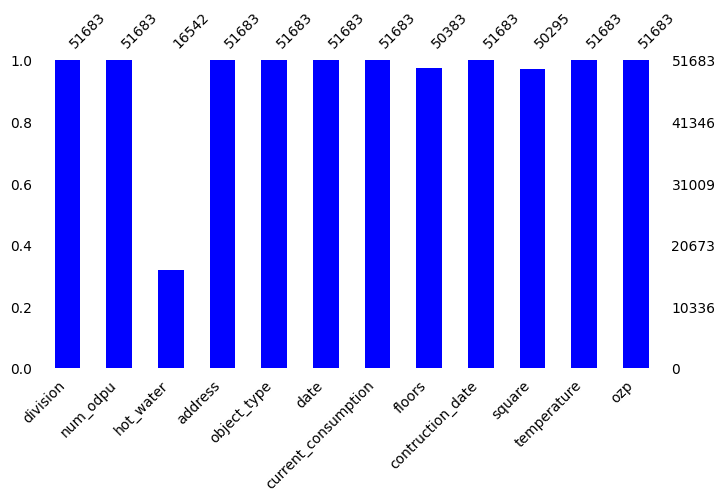

In [ ]:
msno.bar(df, color="blue", figsize=(8, 4), fontsize=10)

Cделаем hot_water булевым.

In [ ]:
df.hot_water = df.hot_water.fillna(0).replace('ГВС-ИТП', 1)

<ipython-input-85-e74857efa5e1>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.hot_water = df.hot_water.fillna(0).replace('ГВС-ИТП', 1)


In [ ]:
df.hot_water.value_counts()

,count
hot_water,
0,35141
1,16542


Попробуем убрать оставшиеся пропуски по МКД.

In [ ]:
df[df.object_type == 'Многоквартирный дом'].isna().sum()

,0
division,0
num_odpu,0
hot_water,0
address,0
object_type,0
date,0
current_consumption,0
floors,569
contruction_date,0
square,569


In [ ]:
(
    df[
        (df.object_type == "Многоквартирный дом")
        & df.floors.isna()
        & (~df.address.str.contains("Подобъект|Подъезд"))
    ]
).address

,address
4082,"г Уфа, ул. Уфимское шоссе, д.4"
8218,"г Уфа, ул. Уфимское шоссе, д.4"
13807,"г Уфа, ул. Уфимское шоссе, д.4"
31167,"г Уфа, ул. Уфимское шоссе, д.4"
35199,"г Уфа, ул. Владивостокская, д.10 корп.3,4"
35227,"г Уфа, ул. Уфимское шоссе, д.4"
39329,"г Уфа, ул. Уфимское шоссе, д.4"


In [ ]:
df.loc[df.address == 'г Уфа, ул. Уфимское шоссе, д.4','floors'] = 9
df.loc[df.address == 'г Уфа, ул. Уфимское шоссе, д.4','contruction_date'] = 1976
df.loc[df.address == 'г Уфа, ул. Владивостокская, д.10 корп.3,4','floors'] = 12
df.loc[df.address == 'г Уфа, ул. Владивостокская, д.10 корп.3,4','contruction_date'] = 2015

задаем процентное значение за которым считаем аномалией

In [ ]:
#разница в потреблении объекта в отношении к средней потребления по группе
cons_deviation_anom_state = 25 #25
#изменение площади объекта относительно прошлого наблюдения
area_dev_anom_state = 10 #10
#изменение потребления относительно того же месяца предшествующего периода
ypy_cons_devi_anom_state = 25 #25
#отклонение от среднего потребления
cons_dev_anom_state = 50 #50

Выделим год, месяц.

In [ ]:
df.date = pd.to_datetime(df.date)
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df.date = df.date.dt.date

Переведем данные в меньший по размеру тип.

In [ ]:
df.contruction_date = df.contruction_date.astype('Int16')
df.year = df.year.astype('Int16')
df.month = df.month.astype('Int8')
df.ozp = df.ozp.astype('Int8')
df.floors = df.floors.astype('Int8')

Заполним пропуски.

In [ ]:
df.square = df.square.fillna(-1)

Разделим дату постройки и этажность на группы.

In [ ]:
df["const_date_group"] = pd.cut(
    df["contruction_date"],
    bins=[-1, 0, 1958, 1989, 2000, 2010, 2024],
    labels=["-1", "<=1958", "1959-1989", "1990-2000", "2001-2010", "2011-2024"],
    include_lowest=True,
)

df["floors_group"] = pd.cut(
    df["floors"],
    bins=[0, 2, 4, 9, 12, float("inf")],
    labels=["1-2", "3-4", "5-9", "10-12", ">=13"],
    include_lowest=True,
)

In [ ]:
df.sample(5)

,division,num_odpu,hot_water,address,object_type,date,current_consumption,floors,contruction_date,square,temperature,ozp,year,month,const_date_group,floors_group
9950,Уфа,24449,0,"г Уфа, ул. Рихарда Зорге, д.66",Многоквартирный дом,2022-02-01,138.2420,17,2005,4922.10,-6.735714,28,2022,2,2001-2010,>=13
20516,Уфа,86595,1,"г Уфа, ул. Путейская, д.6 корп.а",Другое строение,2023-01-01,61.1840,1,-1,0.01,-12.745161,31,2023,1,-1,1-2
11836,Уфа,273474,0,"г Уфа, ул. Новочеркасская, д.13 корп.1",Другое строение,2022-02-01,81.2020,2,-1,0.05,-6.735714,28,2022,2,-1,1-2
40002,Уфа,1404253,0,"г Уфа, пр-кт Октября, д.22 корп.1",Многоквартирный дом,2022-01-01,93.5000,5,1962,3516.90,-11.500000,31,2022,1,1959-1989,5-9
11783,Уфа,101204,0,"г Уфа, ул. Подвойского, д.17",Многоквартирный дом,2022-02-01,106.5611,5,1970,3532.60,-6.735714,28,2022,2,1959-1989,5-9


cons_deviation - разница в потреблении объекта в отношении к средней потребления по группе

In [ ]:
def calculate_deviation(group):
    """Функция для расчета отклонения в группе и записи в новый столбец"""
    group["cons_deviation"] = (
        abs(
            (group["current_consumption"] - group["current_consumption"].mean())
            / group["current_consumption"].mean()
        )
        * 100
    )
    return group

In [ ]:
# df.reset_index(inplace=True)
df = (
    df.groupby(["year", "month", "object_type", "const_date_group", "floors_group"])
    .apply(calculate_deviation)
    .reset_index(drop=True)
)
df.sample(3)

<ipython-input-97-d4434164861a>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["year", "month", "object_type", "const_date_group", "floors_group"])
<ipython-input-97-d4434164861a>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(calculate_deviation)


,division,num_odpu,hot_water,address,object_type,date,current_consumption,floors,contruction_date,square,temperature,ozp,year,month,const_date_group,floors_group,cons_deviation
35773,Уфа,1600742,1,"г Уфа, пр-кт Октября, д.89 корп.4",Многоквартирный дом,2023-01-01,91.4179,5,1964,2675.7,-12.745161,31,2023,1,1959-1989,5-9,34.863360
11611,Уфа,14014274,0,"г Уфа, ул. Черниковская, д.87",Многоквартирный дом,2022-01-01,171.5600,9,1972,7564.2,-11.500000,31,2022,1,1959-1989,5-9,44.723763
910,Уфа,65983,1,"г Уфа, ул. Пекинская, д.17 корп.а",Многоквартирный дом,2021-10-01,12.9790,5,1972,2557.4,6.696552,29,2021,10,1959-1989,5-9,18.768196


In [ ]:
df.cons_deviation = round(df.cons_deviation,0)
df.cons_deviation = df.cons_deviation.fillna(0)
df.cons_deviation =df.cons_deviation.astype(int)

In [ ]:
# df["area_deviation"] = df.groupby(["address", "object_type"])["square"].pct_change()

# if df["address"].nunique() > 1:
#     df.loc[df["area_deviation"].isna(), "area_deviation"] = 0

# df["area_deviation"] = df["area_deviation"].replace([float("inf"), -float("inf")], -1)
# df["area_deviation"] = round(df["area_deviation"], 2)

year_per_year_cons_devi - изменение потребления относительно того же месяца предшествующего периода;

In [ ]:
df = df.sort_values(by=["address", "num_odpu", "year", "month"])
df["year_per_year_cons_devi"] = round(
    abs(df.groupby("address")["current_consumption"].pct_change(periods=7) * 100)
)

if df["address"].nunique() > 1:
    df.loc[df["year_per_year_cons_devi"].isna(), "year_per_year_cons_devi"] = 0

df["year_per_year_cons_devi"] = df["year_per_year_cons_devi"].replace(
    [float("inf"), -float("inf")], 0
)
df["year_per_year_cons_devi"] = df["year_per_year_cons_devi"].astype(int)

cons_per_deg - потребление на градус\
temp_coef - температурный коэффициент\
avg_cons - среднее потребление за 3 месяца\
is_same_as_previous - равные значения показаний в течение нескольких расчетных периодов.

In [ ]:
df["is_same_as_previous"] = (
    df["current_consumption"] == df["current_consumption"].shift(1)
).astype(int)
df["cons_per_deg"] = abs(df["current_consumption"] / df["temperature"])
df["temp_coef"] = df["current_consumption"] / (
    df["temperature"] - df["temperature"].mean()
)
df["avg_cons"] = df["current_consumption"].rolling(window=3).mean()
df.avg_cons.fillna(0, inplace=True)

<ipython-input-101-23e9fefff7bf>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.avg_cons.fillna(0, inplace=True)


cons_dev - отклонение от среднего потребления.

In [ ]:
df["cons_dev"] = round(
    abs(((df["current_consumption"] - df["avg_cons"]) / df["avg_cons"]) * 100), 2
)
df["cons_dev"] = df["cons_dev"].replace([float("inf"), -float("inf")], 0)
df.cons_dev.fillna(0, inplace=True)

<ipython-input-102-ca9f7a1a9691>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.cons_dev.fillna(0, inplace=True)


consumption_diff - лаг потребления Гкал за предыдущий месяц.

In [ ]:
df["prev_consumption"] = df.groupby(["address", "num_odpu", "year"])[
    "current_consumption"
].shift(1)
df["consumption_diff"] = (
    abs((df["current_consumption"] - df["prev_consumption"]) / df["prev_consumption"])
    * 100
)
df["consumption_diff"] = df["consumption_diff"].replace(
    [float("inf"), -float("inf")], 0
)
df.drop("prev_consumption", axis=1, inplace=True)
df.consumption_diff.fillna(0, inplace=True)

<ipython-input-103-70c89f60d945>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.consumption_diff.fillna(0, inplace=True)


temperature_diff - лаг температуры за предыдущий месяц.

In [ ]:
df["prev_temperature"] = df.groupby(["address", "num_odpu", "year"])[
    "temperature"
].shift(1)
df["temperature_diff"] = (df["temperature"] - df["prev_temperature"]) / df[
    "prev_temperature"
]
df["temperature_diff"] = df["temperature_diff"].replace(
    [float("inf"), -float("inf")], 0
)
df.drop("prev_temperature", axis=1, inplace=True)
df.temperature_diff.fillna(0, inplace=True)

<ipython-input-104-58435938fe12>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.temperature_diff.fillna(0, inplace=True)


consumption_times_temperature - произведение потребления Гкал и температуры\
consumption_minus_temperature - разница между потреблением Гкал и температурой.

In [ ]:
df["consumption_times_temperature"] = df["current_consumption"] * df["temperature"]
df["consumption_minus_temperature"] = df["current_consumption"] - df["temperature"]

Выделение улицы из адреса.

In [ ]:
new_cols = (
    df["address"]
    .str.split(", ", expand=True)
    .rename(columns={0: "city", 1: "street", 2: "house", 3: "building"})
)
new_cols.drop(columns = ["house", "building"], axis=1,inplace=True)
# new_cols["building"] = new_cols["house"].str.split(" ", expand=True)[1]
# new_cols["house"] = new_cols["house"].str.split(" ", expand=True)[0]
# new_cols.fillna(0, inplace=True)
# new_cols["building"] = new_cols["house"].astype(str)
# new_cols["house"] = new_cols["house"].astype(str)

In [ ]:
df = df.join(new_cols)
df.drop('address', axis=1,inplace=True)

area_dev_anom - area_deviation* аномалия (True(1),False(0))\
ypy_cons_devi_anom - year_per_year_cons_devi аномалия (True(1),False(0))\
cons_dev_anom - cons_dev аномалия (True(1),False(0))\
anom_sum - сумма таргетов\
anom - anom_sum аномалия (True(1),False(0)).

In [ ]:
df["cons_deviation_anom"] = df["cons_deviation"].apply(
    lambda x: 1 if x > cons_deviation_anom_state else 0
)
# df["area_dev_anom"] = df["area_deviation"].apply(
#     lambda x: 1 if x > area_dev_anom_state else 0
# )
df["ypy_cons_devi_anom"] = df["year_per_year_cons_devi"].apply(
    lambda x: 1 if x > ypy_cons_devi_anom_state else 0
)
df["cons_dev_anom"] = df["cons_dev"].apply(
    lambda x: 1 if x > cons_dev_anom_state else 0
)

df["anom_sum"] = (
    df.is_same_as_previous
    + df.cons_dev_anom
    # + df.area_dev_anom
    + df.ypy_cons_devi_anom
    + df.cons_dev_anom
)

# интересный момент, если добавляем в итоговую метрику cons_deviation_anom (разницу площадей), то метрика падает до 0,3. Может повысить cons_deviation_anom_state?
# data_df['anom_sum'] = data_df.is_same_as_previous + data_df.cons_deviation_anom + data_df.area_dev_anom + data_df.ypy_cons_devi_anom + data_df.cons_dev_anom

df["anom"] = df["anom_sum"].apply(lambda x: 1 if x != 0 else 0)

In [ ]:
categorical_features = df.select_dtypes(include=["object", "category"]).columns.tolist()

label_encoders = {}
for column in categorical_features:
    label_encoders[column] = LabelEncoder()
    df[column] = label_encoders[column].fit_transform(df[column])

print(categorical_features)

['division', 'num_odpu', 'object_type', 'date', 'const_date_group', 'floors_group', 'city', 'street']


In [ ]:
df.isnull().values.any()

False

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50390 entries, 1322 to 46772
Data columns (total 33 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   division                       50390 non-null  int64  
 1   num_odpu                       50390 non-null  int64  
 2   hot_water                      50390 non-null  int64  
 3   object_type                    50390 non-null  int64  
 4   date                           50390 non-null  int64  
 5   current_consumption            50390 non-null  float64
 6   floors                         50390 non-null  Int8   
 7   contruction_date               50390 non-null  Int16  
 8   square                         50390 non-null  float64
 9   temperature                    50390 non-null  float64
 10  ozp                            50390 non-null  Int8   
 11  year                           50390 non-null  Int16  
 12  month                          50390 non-null  I

<Axes: >

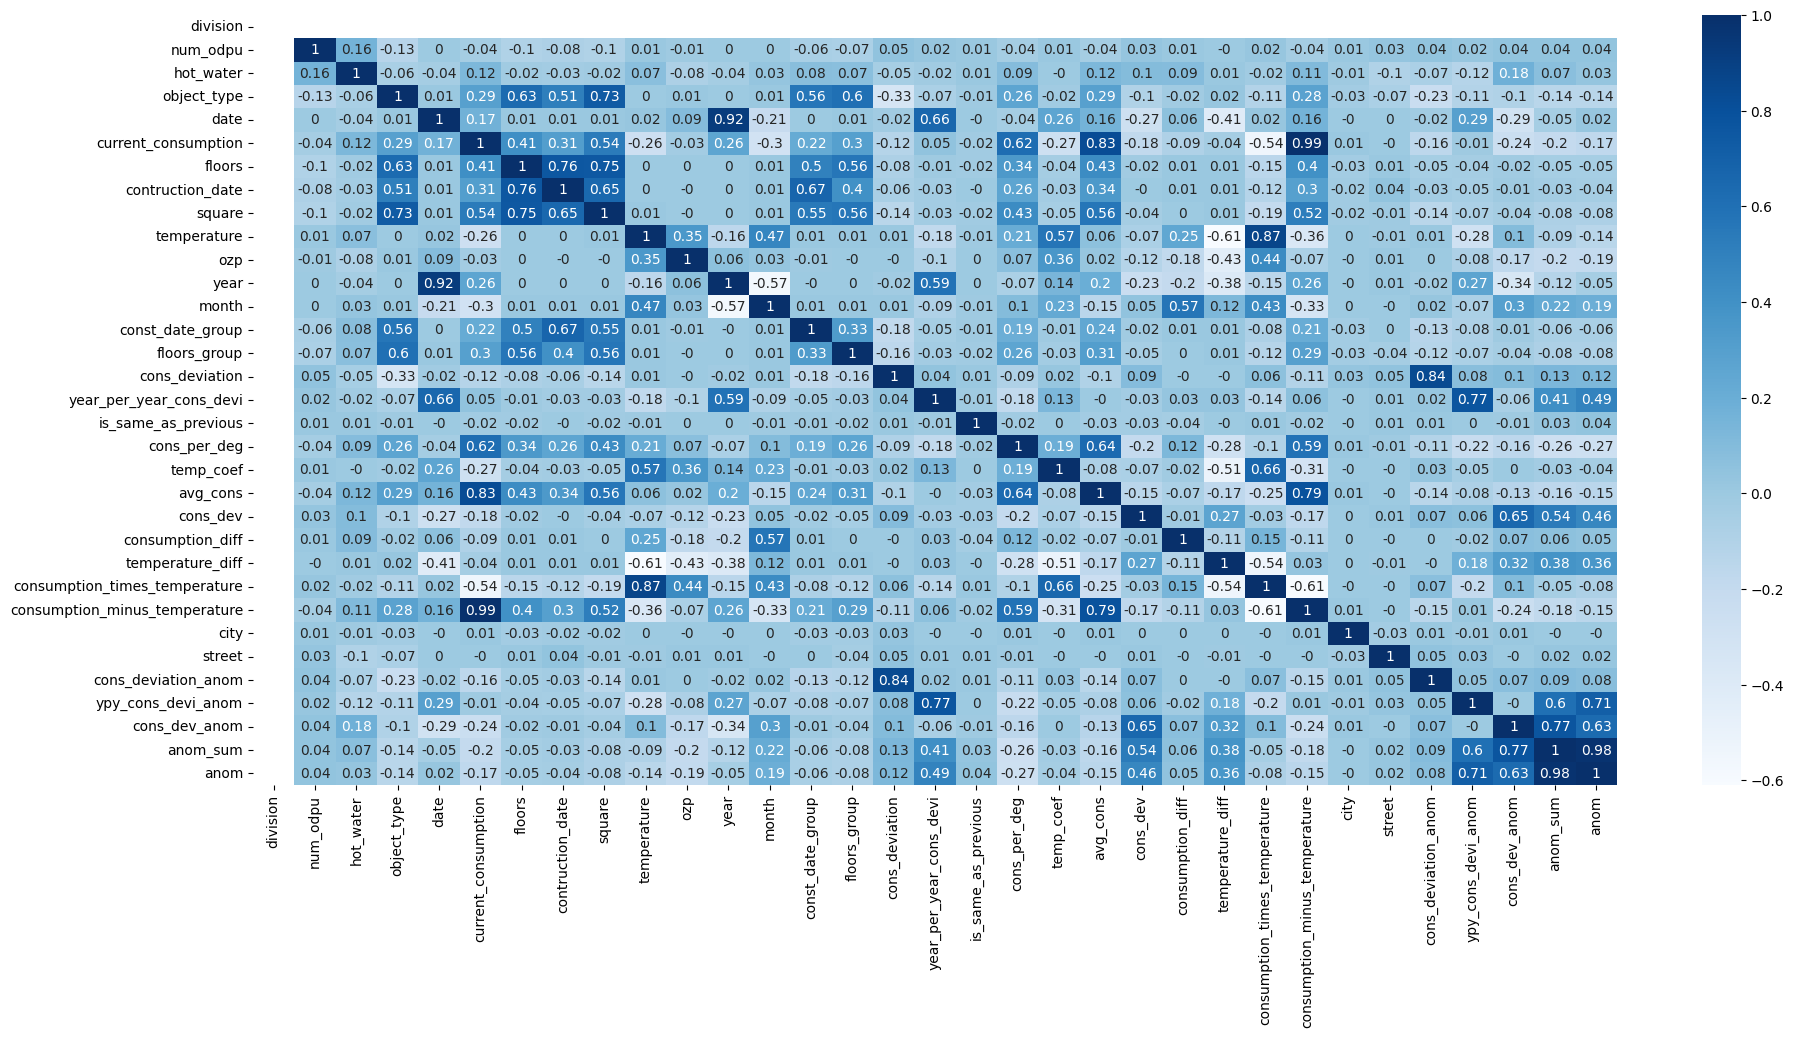

In [ ]:
fig, axes = plt.subplots(figsize=(22, 10))
sns.heatmap(round(df.corr(method='spearman'), 2), annot=True, cmap="Blues")

<ipython-input-113-ce86ec423e01>:3: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['anom'], sort = True)


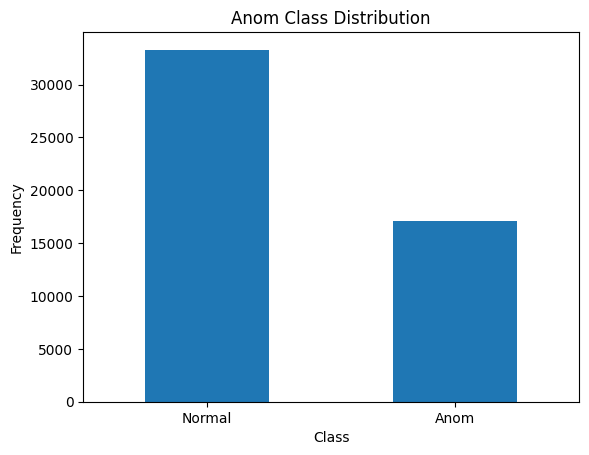

In [ ]:
LABELS = ["Normal", "Anom"]

count_classes = pd.value_counts(df['anom'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Anom Class Distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

In [ ]:
scaler = MinMaxScaler()
data_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [ ]:
df['anom'] = df['anom'].astype(int)

### <div style="border: 1px solid purple; padding: 10px; color: SteelBlue">Модель</div>

In [ ]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[
            i : i + seq_length, :-1
        ]  # Исключаем последний столбец (метку аномалии)
        y = data[i + seq_length, -1]  # Метка аномалии
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)


seq_length = 50  # Длина временного окна
X, y = create_sequences(data_normalized.values, seq_length)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
model = Sequential()
model.add(
    LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True)
)
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
history = model.fit(
    X_train, y_train, epochs=5, batch_size=32, validation_split=0.1, verbose=1
)

Epoch 1/5
1133/1133 ━━━━━━━━━━━━━━━━━━━━ 117s 100ms/step - accuracy: 0.7306 - loss: 0.5280 - val_accuracy: 0.8247 - val_loss: 0.3719
Epoch 2/5
1133/1133 ━━━━━━━━━━━━━━━━━━━━ 141s 99ms/step - accuracy: 0.8308 - loss: 0.3666 - val_accuracy: 0.8421 - val_loss: 0.3414
Epoch 3/5
1133/1133 ━━━━━━━━━━━━━━━━━━━━ 141s 98ms/step - accuracy: 0.8427 - loss: 0.3443 - val_accuracy: 0.8543 - val_loss: 0.3280
Epoch 4/5
1133/1133 ━━━━━━━━━━━━━━━━━━━━ 117s 103ms/step - accuracy: 0.8473 - loss: 0.3350 - val_accuracy: 0.8617 - val_loss: 0.3219
Epoch 5/5
1133/1133 ━━━━━━━━━━━━━━━━━━━━ 138s 99ms/step - accuracy: 0.8530 - loss: 0.3285 - val_accuracy: 0.8637 - val_loss: 0.3151


In [ ]:
y_pred = model.predict(X_test)

315/315 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step


In [ ]:
y_pred = (y_pred > 0.5).astype(int)  # Преобразуем вероятности в метки классов

In [ ]:
print(classification_report(y_test, y_pred))
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

              precision    recall  f1-score   support

         0.0       0.90      0.88      0.89      6744
         1.0       0.77      0.80      0.79      3324

    accuracy                           0.86     10068
   macro avg       0.84      0.84      0.84     10068
weighted avg       0.86      0.86      0.86     10068

F1 Score: 0.7867982908501547


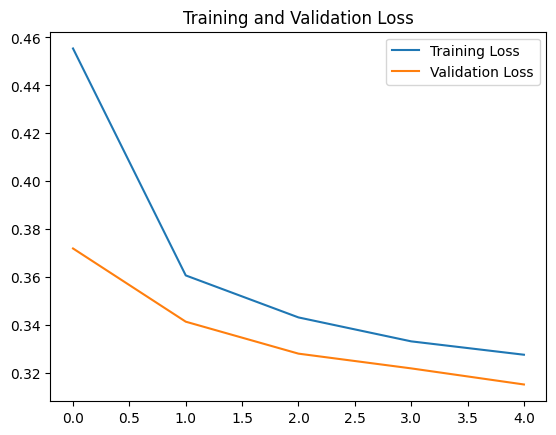

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

Создание DataFrame с предсказанными классами


In [ ]:
y_test_df = pd.DataFrame(y_test, columns=['true_class'])
y_pred_df = pd.DataFrame(y_pred, columns=['predicted_class'])
result_df = pd.concat([y_test_df, y_pred_df], axis=1)

Возврат преобразованных категориальных признаков обратно в исходный вид


In [ ]:
for feature, le in label_encoders.items():
    df[feature] = le.inverse_transform(df[feature])

In [ ]:
anomalies_df = pd.concat([df.iloc[-len(y_test) :].reset_index(), result_df], axis=1)

In [ ]:
anomalies_df.head(2)

,index,division,num_odpu,hot_water,object_type,date,current_consumption,floors,contruction_date,square,...,consumption_minus_temperature,city,street,cons_deviation_anom,ypy_cons_devi_anom,cons_dev_anom,anom_sum,anom,true_class,predicted_class
0,3320,Уфа,72515,0,Многоквартирный дом,2021-11-01,44.139,5,1969,3558.1,...,45.139000,г Уфа,ул. Российская,1,0,1,2,1,0.0,0
1,7292,Уфа,72515,0,Многоквартирный дом,2021-12-01,67.715,5,1969,3558.1,...,72.891667,г Уфа,ул. Российская,1,0,0,0,0,0.0,0


In [ ]:
len(anomalies_df[anomalies_df.predicted_class == 1]) / len(
    anomalies_df[anomalies_df.true_class == 1]
)

1.0418170878459687

In [ ]:
anomalies_df.to_excel('anomalies.xlsx',sheet_name='аномалии', index=False)

In [ ]:
model.save('lstm_anomaly_detection_model.h5')